In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jacobian, jit, vmap, random, nn, tree_multimap

import numpy as np

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.linalg as sl
import scipy.optimize

In [2]:
# modification of (somewhat erroneous) code i found here:
# https://www.numbercrunch.de/blog/2014/08/calculating-the-hermite-functions/

# i realized later that everything here can be derived from what is found here:
# https://en.wikipedia.org/wiki/Hermite_polynomials#Hermite_functions
# go to the part of the entry that deals with "Hermite functions" and then
# search for "Recursion relation"

# compute only the n-th Hermite function at all values in the vector x
def oneherm(n, x):
    if n==0:
        return np.ones_like(x)*np.pi**(-0.25)*np.exp(-x**2/2)
    if n==1:
        return np.sqrt(2.)*x*np.pi**(-0.25)*np.exp(-x**2/2)
    h_i_2 = np.ones_like(x)*np.pi**(-0.25)
    h_i_1 = np.sqrt(2.)*x*np.pi**(-0.25)
    for i in range(2, n+1):
        h_i = np.sqrt(2./i)*x*h_i_1 - np.sqrt((i-1.)/i)*h_i_2
        h_i_2, h_i_1 = h_i_1, h_i
    return h_i*np.exp(-x**2/2) 

# compute all Hermite functions up to the n-th one at all values in the vector x
def allherm(n, x):
    out = np.zeros((n+1, x.shape[0]))
    h_i_2 = np.ones_like(x)*np.pi**(-0.25)
    out[0,:] = h_i_2*np.exp(-x**2/2)
    if n==0:
        return out
    h_i_1 = np.sqrt(2.)*x*np.pi**(-0.25)
    out[1,:] = h_i_1*np.exp(-x**2/2)
    if n==1:
        return out
    for i in range(2, n+1):
        h_i = np.sqrt(2./i)*x*h_i_1 - np.sqrt((i-1.)/i)*h_i_2
        h_i_2, h_i_1 = h_i_1, h_i
        out[i,:] = h_i*np.exp(-x**2/2)
    return out


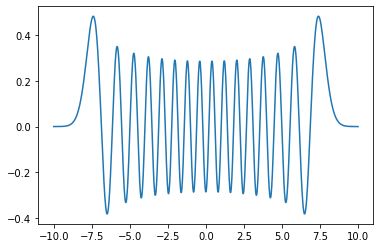

In [3]:
xvec, dx = np.linspace(-10, 10, 1024, retstep=True)
plt.plot(xvec, oneherm(30, xvec))
plt.show()

In [4]:
# check orthonormality
maxdeg = 20
hermmat = allherm(maxdeg, xvec)
print(hermmat.shape)
orthcheck = (hermmat @ hermmat.T) * dx
print(np.linalg.norm(orthcheck - np.eye(maxdeg+1)))

# compute pseudoinverse that can be used to obtain coefficients for a given function
herminv = sl.pinv(hermmat.T) 

(21, 1024)
7.039725676978157e-15


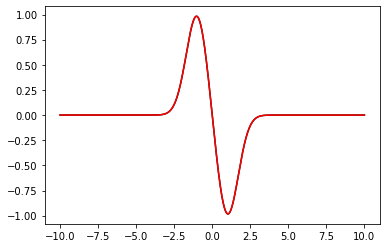

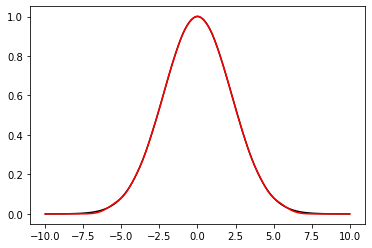

In [5]:
# see if we can find the Hermite function representation of a function in $L^2(\mathbb{R})$
def mypot(x):
    return -np.exp(-(x-1)**2) + np.exp(-(x+1)**2)

hermcoef = herminv @ mypot(xvec)
reconpot = hermcoef @ hermmat

plt.plot(xvec, mypot(xvec), color='black')
plt.plot(xvec, reconpot, color='red')
plt.show()

# try it again for another function in $L^2(\mathbb{R})$
def mypot2(x):
    return np.exp(-0.1*x**2)

hermcoef2 = herminv @ mypot2(xvec)
reconpot2 = hermcoef2 @ hermmat

plt.plot(xvec, mypot2(xvec), color='black')
plt.plot(xvec, reconpot2, color='red')
plt.show()

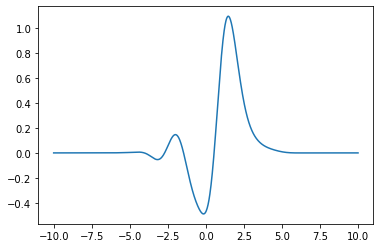

In [6]:
# exponential decay that we apply to a random set of coefficients
decay = np.exp(-0.4*np.arange(maxdeg+1))

# form decaying, random set of coefficients
randcoef = np.random.normal(size=(maxdeg+1))*decay

# evaluate potential for the purposes of plotting
randpot = randcoef @ hermmat
plt.plot(xvec, randpot)
plt.show()

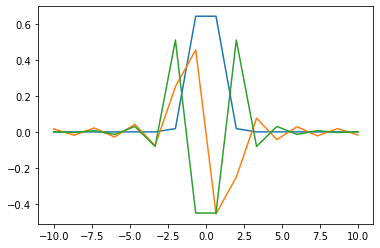

In [7]:
# this is the spatial grid and dx that we'll actually use for learning
num_space_steps = 16
xvec, dx = np.linspace(-10, 10, num_space_steps, retstep=True)
hermmat = allherm(maxdeg, xvec)

space_res = dx
k_res = 1/(num_space_steps * space_res)
k_steps = np.arange(-num_space_steps//2, num_space_steps//2) * k_res
k_terms = np.fft.ifftshift(2 * np.pi * 1j * k_steps)
psi = np.exp(-xvec**2)
psi_hat = np.fft.fft(psi)
psi_hat_prime = k_terms**2 * psi_hat
psi_x = np.fft.ifft(k_terms * psi_hat)
psi_xx = np.fft.ifft(psi_hat_prime)

plt.plot(xvec, psi)
plt.plot(xvec, np.real(psi_x))
plt.plot(xvec, np.real(psi_xx))
plt.show()

6.128622934815108e-15
9.019996107702867e-15
9.019996107702867e-15
1.140204861523586e-15


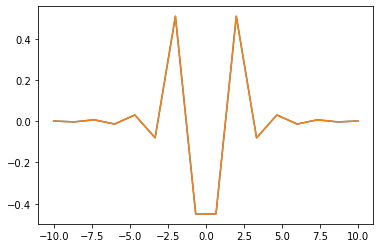

In [8]:
# if you go to this page,
# https://numpy.org/doc/stable/reference/routines.fft.html
# and look up the "implementation details", you'll see an equation where
# 
# A_k = \sum_{m=0}^{n-1} M_{k,m} a_m, 
# 
# with
# 
# M_{k,m} = exp(-2*pi*i*m*k/n)
# 
# here i compute this matrix M in one line and store it in "fftmat"
fftmat = np.exp(-2*np.pi*1j*np.outer(np.arange(num_space_steps), np.arange(num_space_steps))/num_space_steps)

# now i check that multiplying by fftmat is the same as computing the FFT via np.fft.fft
test = fftmat @ psi
print(np.linalg.norm(test - psi_hat))

# we properties of the inverse FFT, we can derive that
ifftmat = (1.0/num_space_steps)*fftmat.conj().T

# let us check that multiplying these gives us the identity matrix
print(np.linalg.norm(fftmat @ ifftmat - np.eye(num_space_steps)))
print(np.linalg.norm(ifftmat @ fftmat - np.eye(num_space_steps)))

# now let us compute the second-derivative matrix
d2mat = ifftmat @ np.diag(k_terms**2) @ fftmat

# let's check if d2mat is Hermitian
print(np.linalg.norm(d2mat - d2mat.conj().T))

# plot second-derivatives computed two different ways
plt.plot(xvec, np.real(psi_xx))
plt.plot(xvec, np.real(d2mat @ psi))
plt.show()

# define the kinetic matrix
kinmat = -0.5*d2mat


In [9]:
# set time step and compute time vector
num_time_steps = 5
dt = 1e-2
tvec = np.arange(num_time_steps)*dt

# form training data
numpots = 40
trainpots = np.zeros((numpots, num_space_steps))
trainwvfns = np.zeros((numpots, num_time_steps, num_space_steps), dtype=np.complex128)

# just to keep things simple, pick the same initial condition for everybody
trainwvfns[:,0,:] = np.exp(-xvec**4)

for i in range(numpots):
    # exponential decay that we apply to a random set of coefficients
    decay = np.exp(-0.4*np.arange(maxdeg+1))

    # form decaying, random set of coefficients
    randcoef = np.random.normal(size=(maxdeg+1))*decay

    # evaluate potential and store
    trainpots[i,:] = randcoef @ hermmat
    
    # form the Hamiltonian
    ham = kinmat + np.diag(trainpots[i,:])
    
    # diagonalize
    hamspec, hamstates = np.linalg.eigh(ham)
    
    # compute unitary propagator
    prop = hamstates @ np.diag(np.exp(-1j*hamspec*dt)) @ hamstates.conj().T
    
    # iterate propagation
    for j in range(num_time_steps-1):
        trainwvfns[i,j+1,:] = prop @ trainwvfns[i,j,:]

trainwvfnsRraw = np.concatenate([np.real(trainwvfns), np.imag(trainwvfns)], axis=2)

# stack inputs in time
# take "stride" snapshots in a row and concatenate them
stride = 3
numslices = trainwvfnsRraw.shape[1]-stride+1
trainwvfnsR = np.zeros((numpots, numslices, 2*stride*num_space_steps))
for j in range(numpots):
    for i in range(numslices):
        trainwvfnsR[j, i, :] = trainwvfnsRraw[j, i:(i+stride), :].reshape((-1))

trainwvfnsR = trainwvfnsR.reshape((-1, 2*stride*num_space_steps))
trainpotsR = np.tile(np.expand_dims(trainpots,1),(1,numslices,1))
trainpotsR = trainpotsR.reshape((-1, num_space_steps))

In [10]:
# set up neural network by hand
numlayers = 4
unitsperlayer = 32

@jit
def relu(x):
    return 0*(x<0) + x*(x>=0)

@jit
def trainpredict(theta, inputs, activation=nn.relu):
    # organize theta as follows:
    # weight, bias
    cnt = 0
    hlist = []
    for layer in range(numlayers+1):
        # the weight in each layer has shape (dim1, dim2)
        # the bias in each layer has shape (dim2,)
        if layer==0:
            dim1 = inputs.shape[1]
        else:
            dim1 = unitsperlayer
        if layer==numlayers:
            dim2 = num_space_steps
        else:
            dim2 = unitsperlayer
        
        # extract weight and bias from theta vector
        thisweight = theta[cnt : (cnt + dim1*dim2)].reshape((dim1, dim2))
        thisbias = theta[(cnt + dim1*dim2) : (cnt + (dim1+1)*dim2)]
        cnt += (dim1+1)*dim2
        
        # forward propagation
        if layer==0:
            hnew = inputs @ thisweight + thisbias
        else:
            hnew = hlist[layer-1] @ thisweight + thisbias
        if layer<numlayers:
            hnew = activation(hnew)
        hlist.append(hnew)
    
    return hlist[numlayers]

def resid(theta):
    return (trainpredict(theta, trainwvfnsR) - trainpotsR).reshape((-1))

def loss(theta):
    return 0.5*jnp.sum(jnp.square(trainpredict(theta, trainwvfnsR) - trainpotsR))

thetaWdim = trainwvfnsR.shape[1]*unitsperlayer + (numlayers-1)*unitsperlayer**2 + unitsperlayer*num_space_steps
thetaBdim = numlayers*unitsperlayer + num_space_steps
thetadim = thetaWdim + thetaBdim
randtheta = np.random.uniform(size=thetadim)

In [11]:
jloss = jit(loss)
jresid = jit(resid)
jacobresid = jacobian(resid)
jjacob = jit(jacobresid)
gradloss = grad(loss)
jgradloss = jit(gradloss)

In [12]:
def bfgsloss(theta):
    thetajax = jnp.array(theta)
    return np.array(jloss(thetajax))

def bfgsjac(theta):
    thetajax = jnp.array(theta)
    return np.array(jgradloss(thetajax))

In [ ]:
# load saved results from earlier optimization
!curl --output reslsx.txt https://raw.githubusercontent.com/kbcollins/mltdse/main/hsb/reslsx.txt?token=ABGSM5UT3553QGFRP2ZP3HTAYZTBY
reslsx = np.loadtxt('reslsx.txt')
jloss(reslsx)

# levenberg-marquardt
resls = scipy.optimize.least_squares(fun=jresid, jac=jjacob, x0=reslsx, verbose=2, 
                                     ftol=1e-10, gtol=1e-10, xtol=1e-14)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  168k  100  168k    0     0  2240k      0 --:--:-- --:--:-- --:--:-- 2240k


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0593e+03                                    2.62e+05    
       1              6         9.8926e+02      7.01e+01       4.67e-01       2.17e+06    
       2              7         2.3227e+01      9.66e+02       1.17e-01       3.24e+05    


In [ ]:
# res = scipy.optimize.minimize(fun=bfgsloss, jac=bfgsjac, x0=resls.x, method='L-BFGS-B', 
#                               options={'iprint': 99})

In [ ]:
# np.savez('reslsx.npz',resls.x)

In [ ]:
def mse(theta):
    return jnp.mean(jnp.square(trainpredict(theta, trainwvfnsR) - trainpotsR))


In [ ]:
mse(resls.x)

In [ ]:
predpots = trainpredict(resls.x, trainwvfnsR)

In [ ]:
predpots.shape

In [ ]:
for i in range(120):
    plt.plot(trainpotsR[i,:],color='black')
    plt.plot(predpots[i,:],color='red')
    if (i+1) % 3 == 0:
        plt.show()